In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../sac_ae")

In [2]:
import torch
import numpy as np
from IPython import display
from ipywidgets import Output, GridspecLayout
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent
from utils.misc import eval_mode, VideoRecorder
from utils.argument import Arguments

In [4]:
def load_agent_and_args(path, model_path=None, device=torch.device('cpu'), add_latest_args=False):
    args = Arguments(path + 'args.json')
    if add_latest_args:
        args.cost_samples = 10
        args.cost_allowed_threshold = 0.05
    if model_path != None:
        weights = torch.load(model_path, map_location=device)
    else:
        weights = torch.load(path + 'best_model.pt', map_location=device)

    if args.agent == 'sac_state':
        agent_obs_shape = weights['actor.encoder.projection.projection.0.weight'].shape[1:]
        args.agent_image_size = agent_obs_shape[0]
    else:
        agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
    action_shape = np.array([4])

    model = make_model(agent_obs_shape, action_shape, args, device)
    agent = make_agent(model, device, action_shape, args)
    agent.load_model_from_dict(weights)
    return agent, args

In [5]:
def calc_success_rate(agent, args, seed, num_episodes=100):
    env = make_envs(args, is_eval=True, use_state=args.agent == 'sac_state')
    env.seed(seed)
    
    num_successes, reward_sum, cost_sum = 0, 0, 0
    
    for i in range(num_episodes): 
        obs = env.reset()

        episode_reward, episode_cost = 0, 0
        done = False

        while not done:
                with eval_mode(agent):
                    #action = agent.select_action(obs)
                    action = agent.sample_action(obs)

                next_obs, reward, done, info = env.step(action)
                episode_reward += reward
                if args.cost != 'no_cost':
                    episode_cost += info['cost']

                obs = next_obs
        reward_sum += episode_reward
        cost_sum += episode_cost
        success = False
        if info.get('is_success'):
            num_successes += 1
            success = True
        #print(f'Episode: {i+1}, Success: {success}, Reward: {np.round(episode_reward, decimals=2)}, Cost: {np.round(episode_cost, decimals=2)}')
    return num_successes / num_episodes, reward_sum / num_episodes, cost_sum / num_episodes

In [6]:
def eval_model(seed, episodes, model_id, model_name=None):
    path = f'../../../output/fetch-push-cost-ensemble/SAC_ensemble_{model_id}/'
    model_path = path + f'model/{model_name}.pt' if model_name != None else None
    agent, args = load_agent_and_args(path, model_path)
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, episodes)
    print(f'Model: {model_name}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

In [28]:
seed = np.random.randint(10000)
print(f'Seed: {seed}')
for model_id in range(3):
    path = f'../../../output/fetch-push-cost-ensemble/SAC_ensemble_{model_id}/'
    agent, args = load_agent_and_args(path)#, path + f'model/{model_name}.pt')
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000)
    print(f'Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

Seed: 1361
Success rate: 0.88, Mean reward: -10.04, Mean cost: 0.87
Success rate: 0.86, Mean reward: -11.14, Mean cost: 0.83
Success rate: 0.81, Mean reward: -11.22, Mean cost: 1.33


In [30]:
%%time
model_base = 3000000
model_names = list(map(lambda x: model_base + x * 25000, range(41)))

for m in model_names:
    eval_model(0, 100, 2, m)

Model: 3000000, Success rate: 0.8, Mean reward: -13.24, Mean cost: 2.57
Model: 3025000, Success rate: 0.81, Mean reward: -12.14, Mean cost: 1.68
Model: 3050000, Success rate: 0.75, Mean reward: -13.04, Mean cost: 2.31
Model: 3075000, Success rate: 0.8, Mean reward: -12.85, Mean cost: 1.62
Model: 3100000, Success rate: 0.8, Mean reward: -10.97, Mean cost: 1.0
Model: 3125000, Success rate: 0.81, Mean reward: -11.53, Mean cost: 1.13
Model: 3150000, Success rate: 0.75, Mean reward: -12.99, Mean cost: 2.34
Model: 3175000, Success rate: 0.81, Mean reward: -12.37, Mean cost: 1.77
Model: 3200000, Success rate: 0.85, Mean reward: -11.6, Mean cost: 1.12
Model: 3225000, Success rate: 0.72, Mean reward: -12.14, Mean cost: 0.82
Model: 3250000, Success rate: 0.87, Mean reward: -11.05, Mean cost: 1.64
Model: 3275000, Success rate: 0.85, Mean reward: -12.25, Mean cost: 2.37
Model: 3300000, Success rate: 0.84, Mean reward: -12.03, Mean cost: 1.03
Model: 3325000, Success rate: 0.89, Mean reward: -10.93,

In [6]:
def record_video(agent, args, seed, video_name, num_episodes=1, pixels=256):
    video = VideoRecorder('./', height=pixels, width=pixels)

    env = make_envs(args, is_eval=True, use_state=args.agent == 'sac_state')
    env.seed(seed)

    video.init()
    video.record(env)
    
    for episode in range(num_episodes):
        obs = env.reset()
        episode_reward, episode_cost = 0, 0
        actions = np.zeros(shape=(env._max_episode_steps, 4))

        for step in range(env._max_episode_steps):
                with eval_mode(agent):
                    if args.cost == 'critic_eval':
                        action = agent.select_low_cost_action(obs)
                    else:
                        action = agent.select_action(obs)
                    actions[step] = action

                next_obs, reward, done, info = env.step(action)
                video.record(env)
                episode_reward += reward
                if args.cost != 'no_cost':
                    episode_cost += info['cost']

                obs = next_obs
        success = False
        if info.get('is_success'):
            success = True
        print(f'Episode: {episode+1} Success: {success}, Reward: {np.round(episode_reward, decimals=2)}, Cost: {np.round(episode_cost, decimals=2)}')
    
    video.save(video_name)
    #return actions

In [8]:
seed = np.random.randint(10000000)
seed

1526233

# Fetch Reach

In [96]:
seed=22

In [97]:
path = '../../../output/final/fetch-reach-final/drq_robot-False_pr-False_2/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)

In [98]:
name = 'drq-no_robot-no_teacher'

In [99]:
record_video(agent, args, seed, f'results/reach/{name}.mp4', num_episodes=1)

Creating window glfw
Episode: 1 Success: True, Reward: -0.6, Cost: 0


In [100]:
display.display(display.Video(f'results/reach/{name}.mp4', html_attributes='loop autoplay'))

# Fetch Push

In [5]:
seed=22

In [6]:
path = '../../../output/final/fetch-push-final/drq_robot-True_pr-False_aa-False_0/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)
name = 'no-teacher'

In [9]:
record_video(agent, args, seed, f'results/push/{name}.mp4', num_episodes=1)
display.display(display.Video(f'results/push/{name}.mp4', html_attributes='loop autoplay'))

Creating window glfw
Episode: 1 Success: False, Reward: -21.21, Cost: 0


In [10]:
path = '../../../output/final/fetch-push-final/drq_robot-True_pr-True_aa-fixed_2/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)
name = 'alpha-1'

In [11]:
record_video(agent, args, seed, f'results/push/{name}.mp4', num_episodes=1)
display.display(display.Video(f'results/push/{name}.mp4', html_attributes='loop autoplay'))

Creating window glfw
Episode: 1 Success: False, Reward: -17.3, Cost: 0


In [12]:
path = '../../../output/final/fetch-push-final/drq_robot-True_pr-True_aa-reward_0/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)
name = 'adaptive-alpha'

In [13]:
record_video(agent, args, seed, f'results/push/{name}.mp4', num_episodes=1)
display.display(display.Video(f'results/push/{name}.mp4', html_attributes='loop autoplay'))

Creating window glfw
Episode: 1 Success: True, Reward: -4.63, Cost: 0


# Fetch Push Barrier State

In [90]:
seed = 0

In [18]:
path = '../../../output/final/fetch-push-barrier-final-2/sac_state_cost-critic_train_1/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)

In [40]:
name = 'sac_state_cost-critic_train'

In [41]:
record_video(agent, args, seed, f'results/push-barrier/{name}.mp4', num_episodes=1)

Creating window glfw
Episode: 1 Success: True, Reward: -8.23, Cost: 0


In [42]:
display.display(display.Video(f'results/push-barrier/{name}.mp4', html_attributes='loop autoplay'))

In [86]:
path = '../../../output/final/fetch-push-barrier-final-2/sac_state_cost-critic_eval_0/'
agent2, args2 = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)

In [87]:
name = 'sac_state_cost-critic_eval'

In [91]:
record_video(agent2, args2, seed, f'results/push-barrier/{name}.mp4', num_episodes=1)

Creating window glfw
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety Evaluation
Safety 

In [92]:
display.display(display.Video(f'results/push-barrier/{name}.mp4', html_attributes='loop autoplay'))

# Fetch Push Barrier DrQ

In [69]:
seed = 22

In [44]:
path = '../../sac_ae/log/CustomFetchPushCostSmallDense-v0-09-29-09-56-im84-b256-s1-drq/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)

In [45]:
name = 'cost_reward'

In [70]:
record_video(agent, args, seed, f'results/push-barrier-drq/{name}.mp4', num_episodes=1)

Creating window glfw
Episode: 1 Success: False, Reward: -25.67, Cost: 0


In [71]:
display.display(display.Video(f'results/push-barrier-drq/{name}.mp4', html_attributes='loop autoplay'))

In [72]:
path = '../../sac_ae/log/CustomFetchPushCostSmallDense-v0-10-05-09-05-im84-b256-s500965-drq/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)

In [73]:
name = 'critic_train'

In [82]:
seed = 2

In [83]:
record_video(agent, args, seed, f'results/push-barrier-drq/{name}.mp4', num_episodes=1)

Creating window glfw
Episode: 1 Success: False, Reward: -20.06, Cost: 0


In [84]:
display.display(display.Video(f'results/push-barrier-drq/{name}.mp4', html_attributes='loop autoplay'))

In [7]:
path = '../../../output/final/fetch-push-barrier-drq-final/drq_critic-train_alpha-05/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)

In [8]:
name = 'critic_train_a-05'

In [71]:
seed = 8

In [72]:
record_video(agent, args, seed, f'results/push-barrier-drq-final/{name}.mp4', num_episodes=1)

Creating window glfw
Episode: 1 Success: False, Reward: -21.83, Cost: 0


In [73]:
display.Video(f'results/push-barrier-drq-final/{name}.mp4', html_attributes='loop autoplay')

# Environment Videos

In [30]:
path = '../../../output/fetch-reach-ae-ensemble/SAC_ensemble_2/'
agent, args = load_agent_and_args(path, path + 'best_model.pt', add_latest_args=True)
name = 'fetch-reach'

In [31]:
seed = 22

In [32]:
record_video(agent, args, seed, f'videos/env/{name}.mp4', num_episodes=1, pixels=512)
display.display(display.Video(f'videos/env/{name}.mp4', html_attributes='loop autoplay'))

Creating window glfw
Episode: 1 Success: True, Reward: -0.37, Cost: 0


In [33]:
path = '../../../output/fetch-push-ae-ensemble/SAC_ensemble_0/'
agent, args = load_agent_and_args(path, path + 'best_model.pt', add_latest_args=True)
name = 'fetch-push'

In [34]:
seed = 22

In [35]:
record_video(agent, args, seed, f'videos/env/{name}.mp4', num_episodes=1, pixels=512)
display.display(display.Video(f'videos/env/{name}.mp4', html_attributes='loop autoplay'))

Creating window glfw
Episode: 1 Success: True, Reward: -2.98, Cost: 0


In [36]:
path = '../../../output/final/fetch-push-barrier-final-2/sac_state_cost-critic_train_1/'
agent, args = load_agent_and_args(path, path + 'model/latest_model.pt', add_latest_args=True)
name = 'fetch-push-barrier'

In [37]:
seed = 0

In [38]:
record_video(agent, args, seed, f'videos/env/{name}.mp4', num_episodes=1, pixels=512)
display.display(display.Video(f'videos/env/{name}.mp4', html_attributes='loop autoplay'))

Creating window glfw
Episode: 1 Success: True, Reward: -8.23, Cost: 0


In [4]:
import cv2

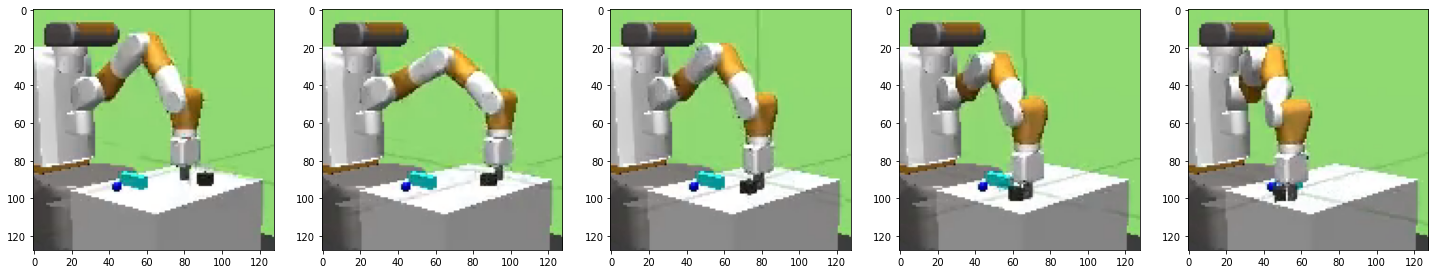

In [8]:
num_images = 5
fig = plt.figure(figsize=(num_images*5, 5))
vidcap = cv2.VideoCapture('results/push-barrier-drq-final/critic_train_a-05.mp4')
vidcap.read()

for i in range(num_images):
    _, image = vidcap.read()
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(image[int(0.15*256): int(0.65*256), int(0.2*256):int(0.7*256)])
    cv2.imwrite(f'results/push-barrier-drq-final/frames/frame_{i}.png', image[int(0.15*256): int(0.65*256), int(0.2*256):int(0.7*256)])
    for k in range(5):
        vidcap.read()
vidcap.release()